# 1. Import libs

In [1]:
import os
import logging
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF

from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import v2

from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# os.mkdir('/kaggle/working/logs') 
# nhớ bỏ ẩn nếu restart

In [4]:
# os.mkdir('/kaggle/working/models')

# 2. Define UNet

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

In [6]:
import timm

class Unet_Resnet(nn.Module):
    def __init__(self, in_channels, out_channels, device):
        super(Unet_Resnet, self).__init__()
        self.device = device  # Store device
        self.encoder = timm.create_model('resnet101', pretrained=True, features_only=True)
        self.encoder = self.encoder.to(device)  # Move to correct device
        # Freeze ResNet encoder parameters
        for param in self.encoder.parameters():
            param.requires_grad = True
        self.bottleneck = DoubleConv(2048, 1024).to(device)  # Move bottleneck to device
        self.final_up = nn.ConvTranspose2d(128, 64, 2, 2).to(device)  # Move final layers to device
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1).to(device)
        self.final_block_up = DoubleConv(128, 64).to(device)
        self.resize = nn.ConvTranspose2d(64, 64, 2, 2).to(device)

    def forward(self, x):
        x = x.to(self.device)  # Ensure input tensor is on the same device as model
        downs = self.encoder(x)
        x = self.bottleneck(downs[-1])
        for i in range(3, 0, -1):
            up = nn.ConvTranspose2d(downs[i].shape[1], downs[i].shape[1] // 2, 2, 2).to(self.device)
            x = up(x)
            concat = torch.concat((x, downs[i]), dim=1)
            block_up = DoubleConv(concat.shape[1], downs[i].shape[1] // 2).to(self.device)
            x = block_up(concat)
        x = self.final_up(x)
        final_concat = torch.concat((x, downs[0]), dim=1)
        x = self.final_block_up(final_concat)
        x = self.resize(x)
        x = self.final_conv(x)
        return x


In [7]:
unet_res = Unet_Resnet(3, 19, device).to(device)
unet_res = nn.DataParallel(unet_res)

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

# 3. Define Dataset and Dataloader

In [8]:
image_size = (512, 1024)

train_transform = v2.Compose([
    v2.Resize((image_size[0], image_size[1]), antialias=True),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


val_transform = v2.Compose([
    v2.Resize((image_size[0], image_size[1]), antialias=True),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [9]:
color_map = np.array([
    [128, 64, 128],   # 0: Road
    [244, 35, 232],   # 1: Sidewalk
    [ 70, 70, 70],    # 2: Building
    [102, 102, 156],  # 3: Wall
    [190, 153, 153],  # 4: Fence
    [153, 153, 153],  # 5: Pole
    [250, 170, 30],   # 6: Traffic light
    [220, 220, 0],    # 7: Traffic sign
    [107, 142, 35],   # 8: Vegetation
    [152, 251, 152],  # 9: Terrain
    [70, 130, 180],   # 10: Sky
    [220, 20, 60],    # 11: Person
    [255, 0, 0],      # 12: Rider
    [0, 0, 142],      # 13: Car
    [0, 0, 70],       # 14: Truck
    [0, 60, 100],     # 15: Bus
    [0, 80, 100],     # 16: Train
    [0, 0, 230],      # 17: Motorcycle
    [119, 11, 32],    # 18: Bicycle
], dtype=np.uint8)

label_mapping = {
    -1: -1,
    0: -1,
    1: -1,
    2: -1,
    3: -1,
    4: -1,
    5: -1,
    6: -1,
    7: 0,
    8: 1,
    9: -1,
    10: -1,
    11: 2,
    12: 3,
    13: 4,
    14: -1,
    15: -1,
    16: -1,
    17: 5,
    18: -1,
    19: 6,
    20: 7,
    21: 8,
    22: 9,
    23: 10,
    24: 11,
    25: 12,
    26: 13,
    27: 14,
    28: 15,
    29: -1,
    30: -1,
    31: 16,
    32: 17,
    33: 18,
}


In [10]:
random.seed(42)
class CityscapeDataset(Dataset):
    def __init__(self, image_dir, mask_dir, split, transform, flip_prob=0.5):
        self.transform = transform
        self.flip_prob = flip_prob

        # Get all input image paths
        self.image_paths = sorted([os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(image_dir+'/'+split)) for f in fn if f.endswith('.png')])
        self.mask_paths = sorted([os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(mask_dir+'/'+split)) for f in fn if f.endswith('_instanceIds.png')])

        if len(self.image_paths) != len(self.mask_paths):
            assert("Warning: Number of images and labels do not match!")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path)

        if random.random() < self.flip_prob:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        
        if self.transform is not None:
            image = self.transform(image)
        # image = image.permute(1, 2, 0)
        
        mask = np.array(mask, dtype=np.int64)
        mask = np.vectorize(lambda x: label_mapping.get(x, -1))(mask)
        mask = torch.tensor(mask, dtype=torch.long)
        return image, mask

In [11]:
imgs_dir = "/kaggle/input/cityscapes/Cityspaces/images"
masks_dir = "/kaggle/input/cityscapes/Cityspaces/gtFine"

In [12]:
train_dataset = CityscapeDataset(imgs_dir, masks_dir, split='train', transform=train_transform, flip_prob=0.5)
val_dataset = CityscapeDataset(imgs_dir, masks_dir, split='val', transform=val_transform, flip_prob=0)

In [13]:
len(train_dataset)

2975

In [14]:
train_dataset[0][0].shape

torch.Size([3, 512, 1024])

In [15]:
len(val_dataset)

500

In [16]:
def get_sampler(dataset):
    if torch.distributed.is_initialized():
        from torch.utils.data.distributed import DistributedSampler
        return DistributedSampler(dataset)
    else:
        return None

In [17]:
train_subset_indices = list(range(600))
val_subset_indices = list(range(50))

train_subset = Subset(train_dataset, train_subset_indices)
train_sampler = get_sampler(train_subset)

val_subset = Subset(val_dataset, val_subset_indices)
val_sampler = get_sampler(val_subset)

In [18]:
num_workers = os.cpu_count()
batch_size = 4

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers, sampler=train_sampler)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers, sampler=val_sampler)

In [19]:
len(train_loader)

150

In [20]:
len(val_loader)

13

In [21]:
img, msk = next(iter(train_loader))

In [22]:
img.shape

torch.Size([4, 3, 512, 1024])

In [23]:
msk.shape

torch.Size([4, 1024, 2048])

# 4. Define controller

In [24]:
def save_model(model, file_path):
    file_path = file_path + '.pth'
    dir_name = os.path.dirname(file_path)
    if dir_name and not os.path.exists(dir_name):
        os.makedirs(dir_name)
    
    # Save
    torch.save(model.state_dict(), file_path)
    print(f"Model is saved to: {file_path}")

In [25]:
# !pip install wandb

In [26]:
# import wandb
# wandb.login()

In [27]:
epochs = 50

In [28]:
# def iou_loss(pred, target, num_classes = 19):
#   pred = F.softmax(pred, dim = 1) # chuyển về thành xác suất cho từng channel
#   iou_per_class = []
#   for c in range(num_classes):
#     pred_c = pred[:,c,:,:] # (B, H, W) cho channel c đang xét
#     target_c = (target == c).float() # trả về 1.0 if index có giá trị là c else 0.0
#     intersection = torch.sum(pred_c * target_c, dim = (1,2)) # tính giao
#     union = torch.sum(pred_c, dim = (1,2)) + torch.sum(target_c, dim = (1,2)) - intersection # tính hợp
#     iou = torch.where(union == 0, torch.tensor(1.0).to(pred.device), intersection / union)  # tính iou, nếu union == 0, gán iou = 1
#     iou_per_class.append(iou)
#     # có thể tính thêm dice loss = 2 * intersection / union + intersection
    
#   mean_iou = torch.mean(torch.stack(iou_per_class, dim = 1), dim = 1) # stack iou theo từng ảnh rồi tính mean iou cho từng ảnh
#   iou_loss = 1 - mean_iou
#   final_loss = torch.mean(iou_loss) # mean iou loss 
#   return final_loss

In [29]:
def iou_loss(output, target, num_classes=19):
    with torch.no_grad():
        # Lấy nhãn dự đoán bằng cách lấy argmax theo chiều classes
        predicted = torch.argmax(output, dim=1)  # [batch_size, height, width]

        # Tạo tensor để lưu trữ tổng IoU cho từng lớp
        ious = []

        # Lấy các lớp xuất hiện trong predicted và target
        classes_in_true = torch.unique(target)
        classes_in_pred = torch.unique(predicted)

        # Loại bỏ lớp -1 khỏi danh sách các lớp cần duyệt trong ground truth
        classes_in_true_no_neg1 = classes_in_true[classes_in_true != -1]

        # Tính IoU cho các lớp có trong ground truth (ngoại trừ lớp -1)
        for cls in classes_in_true_no_neg1:
            cls = cls.item()  # Chuyển sang kiểu int để sử dụng như chỉ mục

            # Mask cho từng lớp
            pred_mask = (predicted == cls)
            true_mask = (target == cls)

            # Tính Intersection và Union
            intersection = torch.sum(pred_mask & true_mask).item()
            union = torch.sum(pred_mask | true_mask).item()

            if union == 0:
                ious.append(float('nan'))  # Nếu không có pixel nào thuộc lớp đó
            else:
                ious.append(intersection / union)

        # Tính IoU cho lớp -1 trong `y_true` với các lớp trong `y_pred` mà không có trong `y_true`
        neg1_pixels = (target == -1)
        if torch.sum(neg1_pixels) > 0:
            pred_classes_not_in_true = torch.tensor(
                [cls for cls in classes_in_pred if cls not in classes_in_true_no_neg1],
                device=target.device
            )

            # Tính IoU cho các pixel lớp -1
            pred_mask_neg1 = torch.isin(predicted, pred_classes_not_in_true)  # Chỉ có trên PyTorch 1.10+
            intersection_neg1 = torch.sum(neg1_pixels & pred_mask_neg1).item()
            union_neg1 = torch.sum(neg1_pixels | pred_mask_neg1).item()

            if union_neg1 == 0:
                ious.append(float('nan'))
            else:
                ious.append(intersection_neg1 / union_neg1)

    # Tính mIoU bằng cách lấy trung bình các IoU, bỏ qua giá trị NaN
    return 1 - torch.tensor(np.nanmean(ious), dtype=float, requires_grad=True)

In [30]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, save_path=None, epochs=10, wandb_writer=None):
    best_loss = float('inf')

    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []
    model.to(device)
    model.train()
    for epoch in range(epochs):
        train_loss, train_acc = 0, 0

        for images, masks in tqdm(train_loader, unit='batch', desc=f'Training [{epoch+1}/{epochs}]'):
            images, masks = images.to(device), masks.to(device)
            
            # with torch.cuda.amp.autocast(enabled=False):
            mask_logits = model(images) # (B, C, H, W)

            # Resize to original size of mask
            mask_logits = F.interpolate(mask_logits, size=(1024, 2048), mode='bilinear', align_corners=False)

            # Loss
            loss = criterion(mask_logits, masks)
            train_loss += loss.item()

            # Update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # scaler.scale(loss).backward()
            # scaler.step(optimizer)
            # scaler.update()

            # Calculate accuracy over pixel
            mask_pred = torch.argmax(mask_logits, dim = 1)
            mask_pred[masks == -1] = -1
            
            valid_mask = masks != -1
            acc_per_batch = torch.eq(mask_pred[valid_mask], masks[valid_mask]).sum().item()
            train_acc += (acc_per_batch / masks.numel())
        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_acc / len(train_loader)
        
        print(f'---> Train loss: {avg_train_loss:.4f}')
        print(f'---> Train acc: {avg_train_acc:.4f}')
        if wandb_writer is not None:    
            wandb_writer.log({"train_loss": avg_train_loss, "train_acc": avg_train_acc, "epoch": epoch + 1})

        train_losses.append(avg_train_loss)
        train_accuracy.append(avg_train_acc)
        
        # Validate
        val_loss, val_acc = 0,0
        model.cuda().eval()
        with torch.inference_mode():
            for images, masks in tqdm(val_loader, unit='batch', desc=f'Validate [{epoch+1}/{epochs}]'):
                images, masks = images.to(device).cuda(), masks.to(device).cuda()
                
                # with torch.cuda.amp.autocast(enabled=False):
                mask_logits = model(images)
                mask_logits = F.interpolate(mask_logits, size=(1024, 2048), mode='bilinear', align_corners=False)
                loss = iou_loss(mask_logits, masks)
                val_loss += loss.item()
                
                mask_pred = torch.argmax(mask_logits, dim = 1)
                mask_pred[masks == -1] = -1
                
                valid_mask = masks != -1
                acc_per_batch = torch.eq(mask_pred[valid_mask], masks[valid_mask]).sum().item()
                val_acc += (acc_per_batch / masks.numel())
        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / len(val_loader)
        
        print(f'---> Valid loss: {avg_val_loss:.4f}')
        print(f'---> Valid acc: {avg_val_acc:.4f}')
        if wandb_writer is not None:
            wandb_writer.log({"val_loss": avg_val_loss, "val_acc": avg_val_acc, "epoch": epoch + 1})
        
        val_losses.append(avg_val_loss)
        val_accuracy.append(avg_val_acc)
        
        if save_path is not None:
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                save_model(model, save_path + f'_epoch{epoch+1}')
                if wandb_writer is not None:
                    wandb_writer.save(f"{save_path}_epoch{epoch+1}.pth")
    if wandb_writer is not None:
        wandb_writer.finish()
    return train_losses, val_losses, train_accuracy, val_accuracy

# 5. Train

In [31]:
lr = 0.003
WD = 0.001
criterion = nn.CrossEntropyLoss(ignore_index = -1)
optimizer = torch.optim.Adam(params = unet_res.parameters(), lr=lr, weight_decay=WD)
# scaler = torch.cuda.amp.GradScaler()

In [32]:
# Initialize W&B project
# unet_res_wandb = wandb.init(
#     project="image-segmentation",  
#     name="unet-res-scratch",     
#     config={                 
#         "epochs": epochs,
#         "batch_size": train_loader.batch_size,
#         "learning_rate": optimizer.defaults['lr'],
#         "weight_decay": optimizer.defaults['weight_decay'],
#         "architecture": unet_res.__class__.__name__,
#     }
# )

In [33]:
save_path = '/kaggle/working/models/unet-res'
train_losses, val_losses, train_accuracy, val_accuracy = train_model(unet_res, train_loader, val_loader, criterion, optimizer, device, save_path, epochs=50)

Training [1/50]:   0%|          | 0/150 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training [1/50]: 100%|██████████| 150/150 [03:01<00:00,  1.21s/batch]


---> Train loss: 0.9216
---> Train acc: 0.5823


Validate [1/50]: 100%|██████████| 13/13 [00:16<00:00,  1.23s/batch]


---> Valid loss: 0.8621
---> Valid acc: 0.4868
Model is saved to: /kaggle/working/models/unet-res_epoch1.pth


Training [2/50]: 100%|██████████| 150/150 [02:53<00:00,  1.16s/batch]


---> Train loss: 1.1370
---> Train acc: 0.5126


Validate [2/50]: 100%|██████████| 13/13 [00:15<00:00,  1.17s/batch]


---> Valid loss: 0.8560
---> Valid acc: 0.5264
Model is saved to: /kaggle/working/models/unet-res_epoch2.pth


Training [3/50]: 100%|██████████| 150/150 [02:53<00:00,  1.16s/batch]


---> Train loss: 0.8791
---> Train acc: 0.5794


Validate [3/50]: 100%|██████████| 13/13 [00:14<00:00,  1.14s/batch]


---> Valid loss: 0.8774
---> Valid acc: 0.4129


Training [4/50]: 100%|██████████| 150/150 [02:53<00:00,  1.16s/batch]


---> Train loss: 0.8498
---> Train acc: 0.5882


Validate [4/50]: 100%|██████████| 13/13 [00:14<00:00,  1.15s/batch]


---> Valid loss: 0.8532
---> Valid acc: 0.5428
Model is saved to: /kaggle/working/models/unet-res_epoch4.pth


Training [5/50]: 100%|██████████| 150/150 [02:53<00:00,  1.16s/batch]


---> Train loss: 0.8243
---> Train acc: 0.5961


Validate [5/50]: 100%|██████████| 13/13 [00:15<00:00,  1.17s/batch]


---> Valid loss: 0.8763
---> Valid acc: 0.5040


Training [6/50]: 100%|██████████| 150/150 [02:53<00:00,  1.16s/batch]


---> Train loss: 0.8431
---> Train acc: 0.5906


Validate [6/50]: 100%|██████████| 13/13 [00:15<00:00,  1.18s/batch]


---> Valid loss: 0.8571
---> Valid acc: 0.5475


Training [7/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.8051
---> Train acc: 0.6041


Validate [7/50]: 100%|██████████| 13/13 [00:15<00:00,  1.18s/batch]


---> Valid loss: 0.8467
---> Valid acc: 0.5394
Model is saved to: /kaggle/working/models/unet-res_epoch7.pth


Training [8/50]: 100%|██████████| 150/150 [02:54<00:00,  1.16s/batch]


---> Train loss: 0.7975
---> Train acc: 0.6023


Validate [8/50]: 100%|██████████| 13/13 [00:15<00:00,  1.17s/batch]


---> Valid loss: 0.8544
---> Valid acc: 0.5470


Training [9/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7831
---> Train acc: 0.6082


Validate [9/50]: 100%|██████████| 13/13 [00:15<00:00,  1.15s/batch]


---> Valid loss: 0.8572
---> Valid acc: 0.5530


Training [10/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7836
---> Train acc: 0.6086


Validate [10/50]: 100%|██████████| 13/13 [00:15<00:00,  1.16s/batch]


---> Valid loss: 0.8587
---> Valid acc: 0.5231


Training [11/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7913
---> Train acc: 0.6047


Validate [11/50]: 100%|██████████| 13/13 [00:15<00:00,  1.17s/batch]


---> Valid loss: 0.8394
---> Valid acc: 0.5681
Model is saved to: /kaggle/working/models/unet-res_epoch11.pth


Training [12/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7717
---> Train acc: 0.6118


Validate [12/50]: 100%|██████████| 13/13 [00:15<00:00,  1.19s/batch]


---> Valid loss: 0.8408
---> Valid acc: 0.5435


Training [13/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7769
---> Train acc: 0.6101


Validate [13/50]: 100%|██████████| 13/13 [00:15<00:00,  1.16s/batch]


---> Valid loss: 0.8452
---> Valid acc: 0.5212


Training [14/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7927
---> Train acc: 0.6075


Validate [14/50]: 100%|██████████| 13/13 [00:14<00:00,  1.13s/batch]


---> Valid loss: 0.8525
---> Valid acc: 0.5308


Training [15/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7614
---> Train acc: 0.6145


Validate [15/50]: 100%|██████████| 13/13 [00:14<00:00,  1.13s/batch]


---> Valid loss: 0.8435
---> Valid acc: 0.5434


Training [16/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7804
---> Train acc: 0.6087


Validate [16/50]: 100%|██████████| 13/13 [00:15<00:00,  1.18s/batch]


---> Valid loss: 0.8589
---> Valid acc: 0.5182


Training [17/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7777
---> Train acc: 0.6110


Validate [17/50]: 100%|██████████| 13/13 [00:15<00:00,  1.21s/batch]


---> Valid loss: 0.8574
---> Valid acc: 0.5423


Training [18/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7553
---> Train acc: 0.6170


Validate [18/50]: 100%|██████████| 13/13 [00:14<00:00,  1.13s/batch]


---> Valid loss: 0.8512
---> Valid acc: 0.5184


Training [19/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7632
---> Train acc: 0.6145


Validate [19/50]: 100%|██████████| 13/13 [00:14<00:00,  1.15s/batch]


---> Valid loss: 0.8376
---> Valid acc: 0.5586
Model is saved to: /kaggle/working/models/unet-res_epoch19.pth


Training [20/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7684
---> Train acc: 0.6142


Validate [20/50]: 100%|██████████| 13/13 [00:14<00:00,  1.14s/batch]


---> Valid loss: 0.8564
---> Valid acc: 0.4929


Training [21/50]: 100%|██████████| 150/150 [02:51<00:00,  1.15s/batch]


---> Train loss: 0.7563
---> Train acc: 0.6155


Validate [21/50]: 100%|██████████| 13/13 [00:15<00:00,  1.18s/batch]


---> Valid loss: 0.8496
---> Valid acc: 0.5502


Training [22/50]: 100%|██████████| 150/150 [02:51<00:00,  1.14s/batch]


---> Train loss: 0.7600
---> Train acc: 0.6134


Validate [22/50]: 100%|██████████| 13/13 [00:15<00:00,  1.17s/batch]


---> Valid loss: 0.8517
---> Valid acc: 0.5376


Training [23/50]: 100%|██████████| 150/150 [02:51<00:00,  1.15s/batch]


---> Train loss: 0.7483
---> Train acc: 0.6172


Validate [23/50]: 100%|██████████| 13/13 [00:14<00:00,  1.15s/batch]


---> Valid loss: 0.8588
---> Valid acc: 0.5324


Training [24/50]: 100%|██████████| 150/150 [02:51<00:00,  1.15s/batch]


---> Train loss: 0.7672
---> Train acc: 0.6134


Validate [24/50]: 100%|██████████| 13/13 [00:14<00:00,  1.13s/batch]


---> Valid loss: 0.8592
---> Valid acc: 0.5311


Training [25/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7494
---> Train acc: 0.6156


Validate [25/50]: 100%|██████████| 13/13 [00:15<00:00,  1.16s/batch]


---> Valid loss: 0.8551
---> Valid acc: 0.5494


Training [26/50]: 100%|██████████| 150/150 [02:51<00:00,  1.14s/batch]


---> Train loss: 0.7486
---> Train acc: 0.6184


Validate [26/50]: 100%|██████████| 13/13 [00:15<00:00,  1.17s/batch]


---> Valid loss: 0.8433
---> Valid acc: 0.5588


Training [27/50]: 100%|██████████| 150/150 [02:51<00:00,  1.14s/batch]


---> Train loss: 0.7597
---> Train acc: 0.6152


Validate [27/50]: 100%|██████████| 13/13 [00:14<00:00,  1.13s/batch]


---> Valid loss: 0.8479
---> Valid acc: 0.5488


Training [28/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7500
---> Train acc: 0.6164


Validate [28/50]: 100%|██████████| 13/13 [00:14<00:00,  1.14s/batch]


---> Valid loss: 0.8366
---> Valid acc: 0.5692
Model is saved to: /kaggle/working/models/unet-res_epoch28.pth


Training [29/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7471
---> Train acc: 0.6181


Validate [29/50]: 100%|██████████| 13/13 [00:15<00:00,  1.15s/batch]


---> Valid loss: 0.8526
---> Valid acc: 0.5103


Training [30/50]: 100%|██████████| 150/150 [02:51<00:00,  1.14s/batch]


---> Train loss: 0.7494
---> Train acc: 0.6169


Validate [30/50]: 100%|██████████| 13/13 [00:15<00:00,  1.18s/batch]


---> Valid loss: 0.8578
---> Valid acc: 0.4944


Training [31/50]: 100%|██████████| 150/150 [02:51<00:00,  1.14s/batch]


---> Train loss: 0.7539
---> Train acc: 0.6162


Validate [31/50]: 100%|██████████| 13/13 [00:14<00:00,  1.15s/batch]


---> Valid loss: 0.8521
---> Valid acc: 0.5221


Training [32/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7624
---> Train acc: 0.6137


Validate [32/50]: 100%|██████████| 13/13 [00:15<00:00,  1.16s/batch]


---> Valid loss: 0.8577
---> Valid acc: 0.5274


Training [33/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7513
---> Train acc: 0.6149


Validate [33/50]: 100%|██████████| 13/13 [00:14<00:00,  1.13s/batch]


---> Valid loss: 0.8306
---> Valid acc: 0.5752
Model is saved to: /kaggle/working/models/unet-res_epoch33.pth


Training [34/50]: 100%|██████████| 150/150 [02:53<00:00,  1.15s/batch]


---> Train loss: 0.7447
---> Train acc: 0.6190


Validate [34/50]: 100%|██████████| 13/13 [00:15<00:00,  1.17s/batch]


---> Valid loss: 0.8456
---> Valid acc: 0.5587


Training [35/50]: 100%|██████████| 150/150 [02:53<00:00,  1.16s/batch]


---> Train loss: 0.7699
---> Train acc: 0.6111


Validate [35/50]: 100%|██████████| 13/13 [00:15<00:00,  1.19s/batch]


---> Valid loss: 0.8462
---> Valid acc: 0.5565


Training [36/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7420
---> Train acc: 0.6201


Validate [36/50]: 100%|██████████| 13/13 [00:14<00:00,  1.13s/batch]


---> Valid loss: 0.8480
---> Valid acc: 0.5415


Training [37/50]: 100%|██████████| 150/150 [02:53<00:00,  1.16s/batch]


---> Train loss: 0.7353
---> Train acc: 0.6212


Validate [37/50]: 100%|██████████| 13/13 [00:14<00:00,  1.13s/batch]


---> Valid loss: 0.8400
---> Valid acc: 0.5516


Training [38/50]: 100%|██████████| 150/150 [02:51<00:00,  1.14s/batch]


---> Train loss: 0.7418
---> Train acc: 0.6189


Validate [38/50]: 100%|██████████| 13/13 [00:14<00:00,  1.14s/batch]


---> Valid loss: 0.8467
---> Valid acc: 0.5224


Training [39/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7544
---> Train acc: 0.6167


Validate [39/50]: 100%|██████████| 13/13 [00:15<00:00,  1.20s/batch]


---> Valid loss: 0.8504
---> Valid acc: 0.5254


Training [40/50]: 100%|██████████| 150/150 [02:53<00:00,  1.16s/batch]


---> Train loss: 0.7329
---> Train acc: 0.6220


Validate [40/50]: 100%|██████████| 13/13 [00:15<00:00,  1.19s/batch]


---> Valid loss: 0.8430
---> Valid acc: 0.5229


Training [41/50]: 100%|██████████| 150/150 [02:51<00:00,  1.14s/batch]


---> Train loss: 0.7393
---> Train acc: 0.6185


Validate [41/50]: 100%|██████████| 13/13 [00:14<00:00,  1.14s/batch]


---> Valid loss: 0.8504
---> Valid acc: 0.5458


Training [42/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7437
---> Train acc: 0.6194


Validate [42/50]: 100%|██████████| 13/13 [00:14<00:00,  1.14s/batch]


---> Valid loss: 0.8446
---> Valid acc: 0.5460


Training [43/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7533
---> Train acc: 0.6156


Validate [43/50]: 100%|██████████| 13/13 [00:15<00:00,  1.19s/batch]


---> Valid loss: 0.8346
---> Valid acc: 0.5550


Training [44/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7411
---> Train acc: 0.6191


Validate [44/50]: 100%|██████████| 13/13 [00:15<00:00,  1.16s/batch]


---> Valid loss: 0.8520
---> Valid acc: 0.5350


Training [45/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7268
---> Train acc: 0.6238


Validate [45/50]: 100%|██████████| 13/13 [00:14<00:00,  1.15s/batch]


---> Valid loss: 0.8602
---> Valid acc: 0.5155


Training [46/50]: 100%|██████████| 150/150 [02:51<00:00,  1.14s/batch]


---> Train loss: 0.7387
---> Train acc: 0.6223


Validate [46/50]: 100%|██████████| 13/13 [00:14<00:00,  1.13s/batch]


---> Valid loss: 0.8377
---> Valid acc: 0.5594


Training [47/50]: 100%|██████████| 150/150 [02:51<00:00,  1.14s/batch]


---> Train loss: 0.7427
---> Train acc: 0.6202


Validate [47/50]: 100%|██████████| 13/13 [00:14<00:00,  1.13s/batch]


---> Valid loss: 0.8442
---> Valid acc: 0.5534


Training [48/50]: 100%|██████████| 150/150 [02:51<00:00,  1.14s/batch]


---> Train loss: 0.7403
---> Train acc: 0.6186


Validate [48/50]: 100%|██████████| 13/13 [00:15<00:00,  1.17s/batch]


---> Valid loss: 0.8478
---> Valid acc: 0.5417


Training [49/50]: 100%|██████████| 150/150 [02:51<00:00,  1.15s/batch]


---> Train loss: 0.7337
---> Train acc: 0.6219


Validate [49/50]: 100%|██████████| 13/13 [00:14<00:00,  1.14s/batch]


---> Valid loss: 0.8396
---> Valid acc: 0.5602


Training [50/50]: 100%|██████████| 150/150 [02:52<00:00,  1.15s/batch]


---> Train loss: 0.7376
---> Train acc: 0.6206


Validate [50/50]: 100%|██████████| 13/13 [00:14<00:00,  1.14s/batch]

---> Valid loss: 0.8467
---> Valid acc: 0.5360


# 6. Visualize results

Text(0.5, 1.0, 'Train Accuracy')

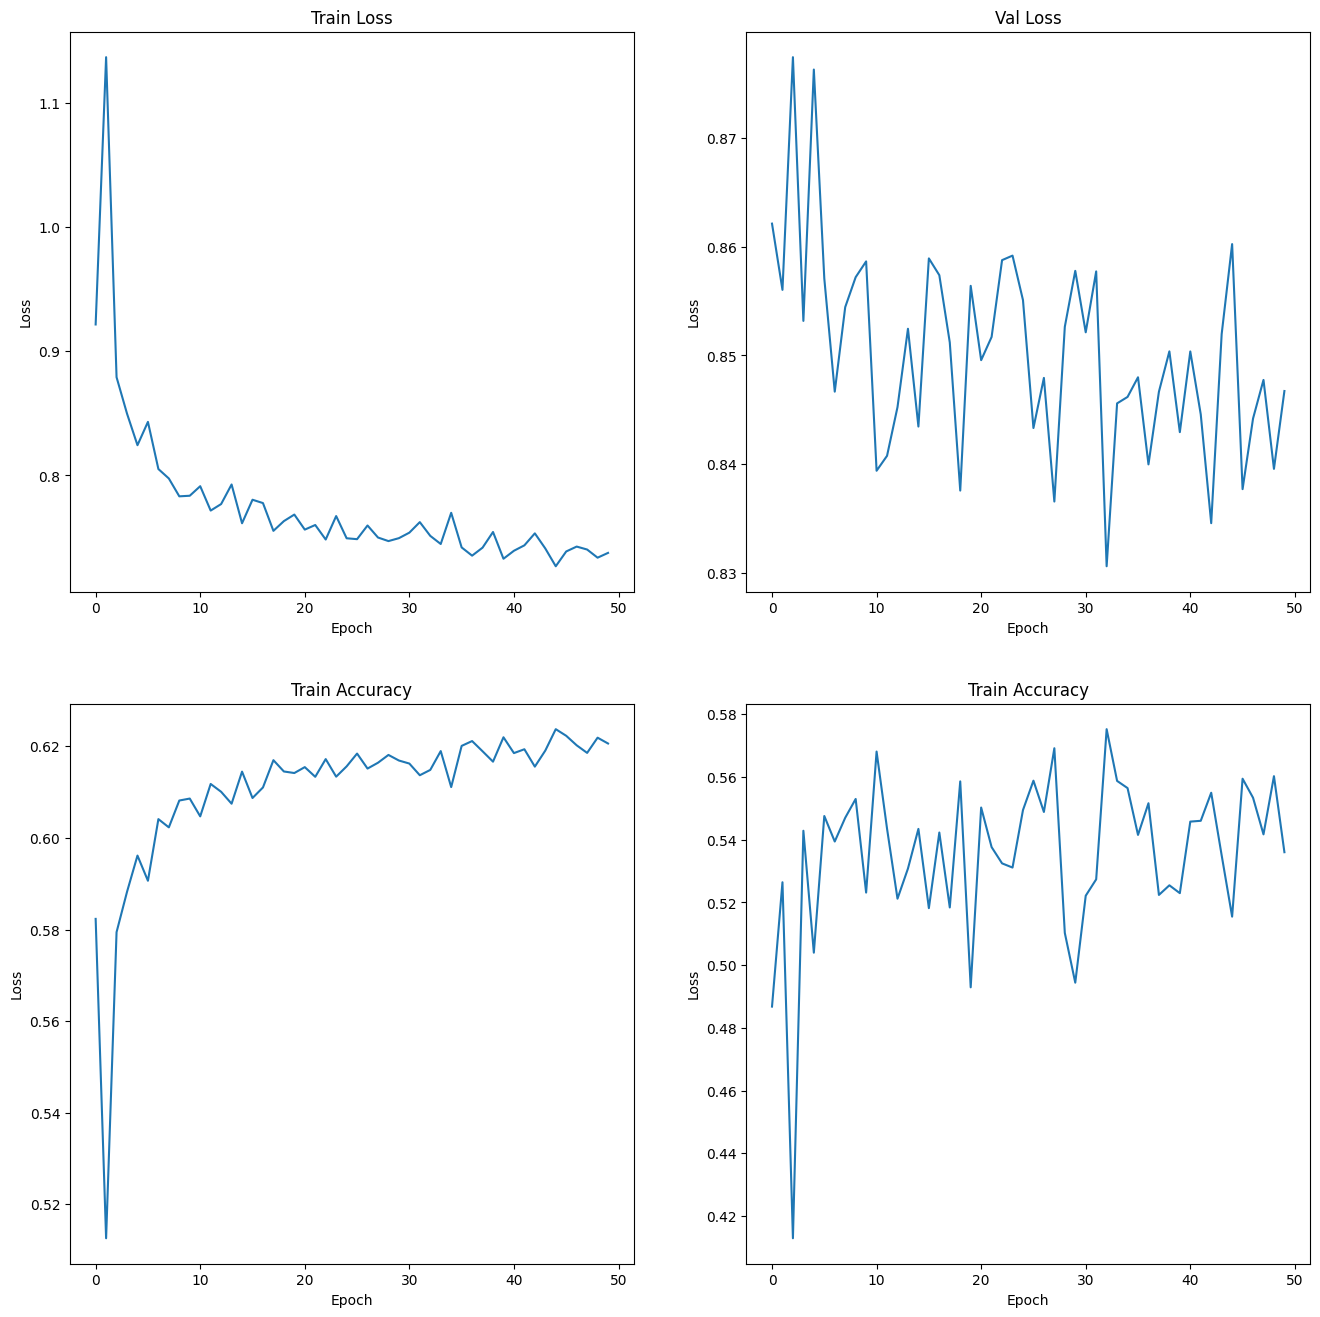

In [34]:
plt.figure(figsize=(16, 16))

plt.subplot(2, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Train Loss")

plt.subplot(2, 2, 2)
plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Val Loss")

plt.subplot(2, 2, 3)
plt.plot(train_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Train Accuracy")

plt.subplot(2, 2, 4)
plt.plot(val_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Train Accuracy")

In [45]:
def get_mask(model, image):
    """
        model: UNet model
        image: input image, size of (B, C, W, H)
    """
    # Compute logit
    model.eval()
    mask_logit = model(image)
    mask_logit = F.interpolate(mask_logit, size=(1024, 2048), mode='bilinear', align_corners=False)
    print(mask_logit.shape)
    mask_logit = mask_logit.permute(0, 2, 3, 1)
    mask_pred = torch.argmax(mask_logit, dim = -1) # Get label
    print(mask_pred.shape)
    mask_pred = mask_pred.squeeze() # Remove batch
    mask_pred = mask_pred.cpu().numpy()
    print(mask_pred.shape)
    
    # Color mapping
    rgb_mask = np.zeros((1024, 2048, 3), dtype=np.uint8)
    for class_id in range(color_map.shape[0]):
        rgb_mask[mask_pred == class_id] = color_map[class_id]

    return rgb_mask

In [46]:
def show_img(path):
    image = Image.open(path).convert('RGB')
    original_size = image.size
    
    print(original_size)
    plt.imshow(image)

(2048, 1024)


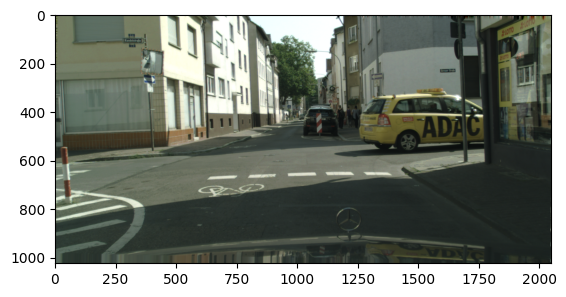

In [47]:
img_path = '/kaggle/input/cityscapes/Cityspaces/images/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png'

show_img(img_path)

(2048, 1024)


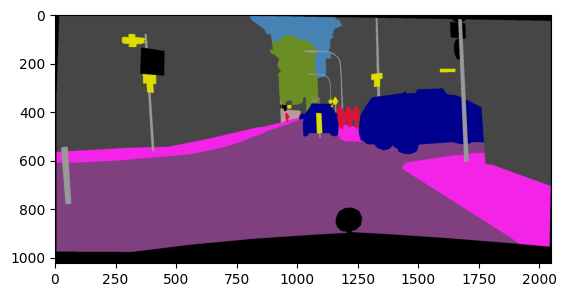

In [48]:
gt = '/kaggle/input/cityscapes/Cityspaces/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_color.png'
show_img(gt)

In [63]:
img = val_subset[0]
in_img = torch.Tensor(img[0].unsqueeze(0))
pred = get_mask(unet_res, in_img)

torch.Size([1, 19, 1024, 2048])
torch.Size([1, 1024, 2048])
(1024, 2048)


In [64]:
pred_img = Image.fromarray(pred)

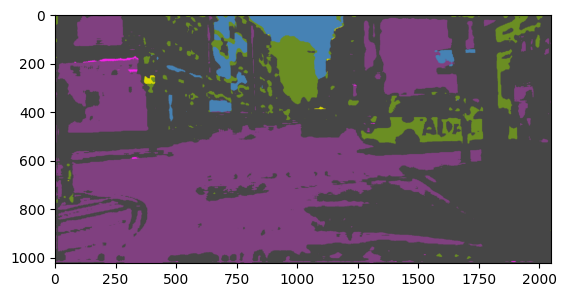

In [65]:
plt.imshow(pred_img)